<a href="https://colab.research.google.com/github/sramponi86/CAS_AIS_LLM/blob/main/CAS_project3_legal_judgement_prediction_4clust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Legal judgement prediction

For this project, we will use the **ECHR dataset**, a collection of 11.5K court cases extracted from the public database of the European Court of Human Rights and further annotated by human experts (more info [here](https://www.aclweb.org/anthology/P19-1424/)). You will develop NLP models that, given the facts of a case, predict whether a human rights article or protocol has been violated. We call such problems *binary classification*.

We will start from simple logistic regression classifiers that use bag-of-words representations of a court case as features, then move to bidirectional LSTM classifiers with frozen and adaptive embeddings, and conclude with pre-trained and fine-tuned Transformer language models.

For those who want to go above and beyond, or simply exercise their NLP classification skills further, it is possible to work on a non-mandatory project extension. Here, you will build models that predict a court case's "importance score". This is a value from 1 to 4 that allows legal practitioners to identify pivotal cases. You will address this as a *multi-class classification* problem. But more on this later!

All of the binary classification tasks, which are mandatory, are based on notions and code that you have been exposed to through lectures and/or tutorials.

## Preliminary data analysis

Let's begin by loading the dataset. The ECHR dataset is open-source and can be downloaded from [this web page](https://archive.org/details/ECHR-ACL2019), but we are going to load a cleaner version of it, which has been pre-processed for this course.

For that, we will need the `datasets` library installed.

In [1]:
!pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00


Now we can import the `load_dataset` from `datasets`, as well as the `pandas` library.

In [2]:
!pip install fsspec==2023.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from datasets import load_dataset


We load the data from the Hugging Face dataset hub and we store it in a pandas dataframe.

In [4]:
dataset = load_dataset("glnmario/ECHR")
full_data = pd.DataFrame(dataset['train'])

# Here, 'train' is just the default name for single-partition datasets.
# The actual training, development, and test set are defined in the
# first column of the dataframe ('partition').


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

***Display and inspect the first 5 rows of the dataset.***

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['partition', 'itemid', 'languageisocode', 'respondent', 'branch', 'date', 'docname', 'importance', 'conclusion', 'judges', 'text', 'binary_judgement'],
        num_rows: 11478
    })
})

As it is common for datasets used in Machine Learning projects, the dataset is split into 3 partitions: training, development, and test set. The training and development sets contain cases from 1959 through 2013, and the test set from 2014 through 2018.
> Note: *It's good practice to never look at the test set during development, as the test set represents the data your Machine Learning system will have to deal with once deployed, which you can't observe at development time. Here, we will keep the test set at hand but you should avoid making any modelling decision based on its content or features. Furthermore, for data which covers a significant period of time (as we have it here), it's best to use the most recent portion of the data as test data, as this will be most similar to the real-world data for which we will use the system.*

The sizes of the partitions, in terms of number of court cases, are the following:

In [7]:
print("Training set     ", len(full_data[full_data.partition == "train"]))
print("Development set  ", len(full_data[full_data.partition == "dev"]))
print("Test set         ", len(full_data[full_data.partition == "test"]))
print("Total           ", len(full_data))

Training set      7100
Development set   1380
Test set          2998
Total            11478


Each instance in this dataset is a court case. Each court case is annotated with the following properties (the columns of the dataframe):

*   `partition`: a label indicating dataset partition this court case belongs to ("train", "dev", or "test")
*   `itemid`: a code which uniquely identifies this court case
*   `languageisocode`: an [ISO code](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes) describing the language in which the case is reported
*   `respondent`: the ISO code of the party being sued or tried (respondents are nation states)
*   `branch`: the branch of the Court dealing with the case, indicating at which stage of the trial a judgement was made (it can be one out of "ADMISSIBILITY", "CHAMBER", "GRANDCHAMBER", "COMMITTEE")
*   `date`: the date of the judgement
*   `docname`: the title of the court case (for example, "ERIKSON v. ITALY")
*   `importance`: an "importance score" from 1 (key case) to 4 (unimportant), denoting a case's contribution in the development of case-law
*   `conclusion`: a short summary of the case conclusion (for example, "Inadmissible" or "Violation of Art. 6-1; No violation of Art. 10"
*   `judges`: the name of the judges
*   `text`: the facts brought to the attention of the Court
*   `binary_judgement`: a binary label indicating whether an article or protocol was (1) or wasn't (0) violated


In [8]:
full_data.columns

Index(['partition', 'itemid', 'languageisocode', 'respondent', 'branch',
       'date', 'docname', 'importance', 'conclusion', 'judges', 'text',
       'binary_judgement'],
      dtype='object')

 ### Filter court cases based on length
 We are now going to filter out from the dataset the court cases with the longest texts. We will do this for two reasons. First, this will speed up the experiments. Second, the Transformer model that we will use at the end of the project has, like most Transormers, a limited *window size*, which cannot fit more than 2048 tokens. This is the maximum sequence length that a Transformer can process at a time.

***Set a threshold by inspecting how many data points it tosses out and how balanced the sizes of the different partitions are (see the next four code cells). The threshold should be smaller than 2048, but greater than or equal to 300.***

In [9]:
THRESHOLD = 2047

Let's look at basic text length statistics and how many court cases are left out when using a certain threshold.

First, we measure the length of every text in the dataset. We do this by splitting each text into words as indicated by whitespace characters, and then counting the number of resulting words.

In [10]:
# Extract text lengths using whitespaces as a simple criterion to separate words
text_lengths = []
for text in full_data.text:
  word_list = text.split()
  num_words = len(word_list)
  text_lengths.append(num_words)

Now can plot the distribution of text lengths, marking the threshold with a vertical line.

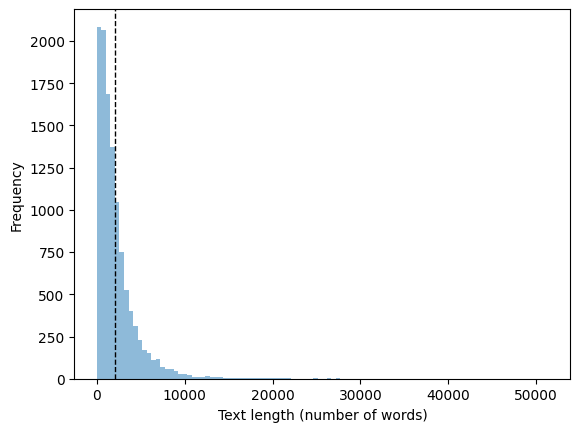

In [11]:
import matplotlib.pyplot as plt

# Plot text lengths
plt.hist(text_lengths, bins=100, alpha=0.5)
plt.ylabel('Frequency')
plt.xlabel('Text length (number of words)')

# Add a vertical bar corresponding to the threshold
plt.axvline(THRESHOLD, color='k', linestyle='dashed', linewidth=1)

plt.show()

As you can see this leaves out quite a few court cases, but it is okay for the purposes of this project.

In [12]:
# Add text length as an extra column to the dataset
full_data['text_length'] = text_lengths

# Calculate how many cases are discarded
n_left_out = sum(full_data.text_length > THRESHOLD)
print(f"Omitting {n_left_out} long cases.")

# Filter out court cases with a text length larger than the threshold
data = full_data[full_data.text_length <= THRESHOLD]

Omitting 4321 long cases.


Let's also make sure the dataset is still reasonably balanced with respect to the training, validation, and test partitions.

In [13]:
print("Training set     ", len(data[data.partition == "train"]))
print("Development set  ", len(data[data.partition == "dev"]))
print("Test set         ", len(data[data.partition == "test"]))
print("Total           ", len(data))

Training set      4332
Development set   823
Test set          2002
Total            7157


### Data visualization

Now that we have our final version of the dataset, let's visualise the distribution of some of the dataset properties (date, branch, respondent, etc.) to get a sense of the data. What time span does the dataset cover? How many cases make it to the Grand Chamber? Which countries have been sued most often?

***Fill in the code for the second plot.***

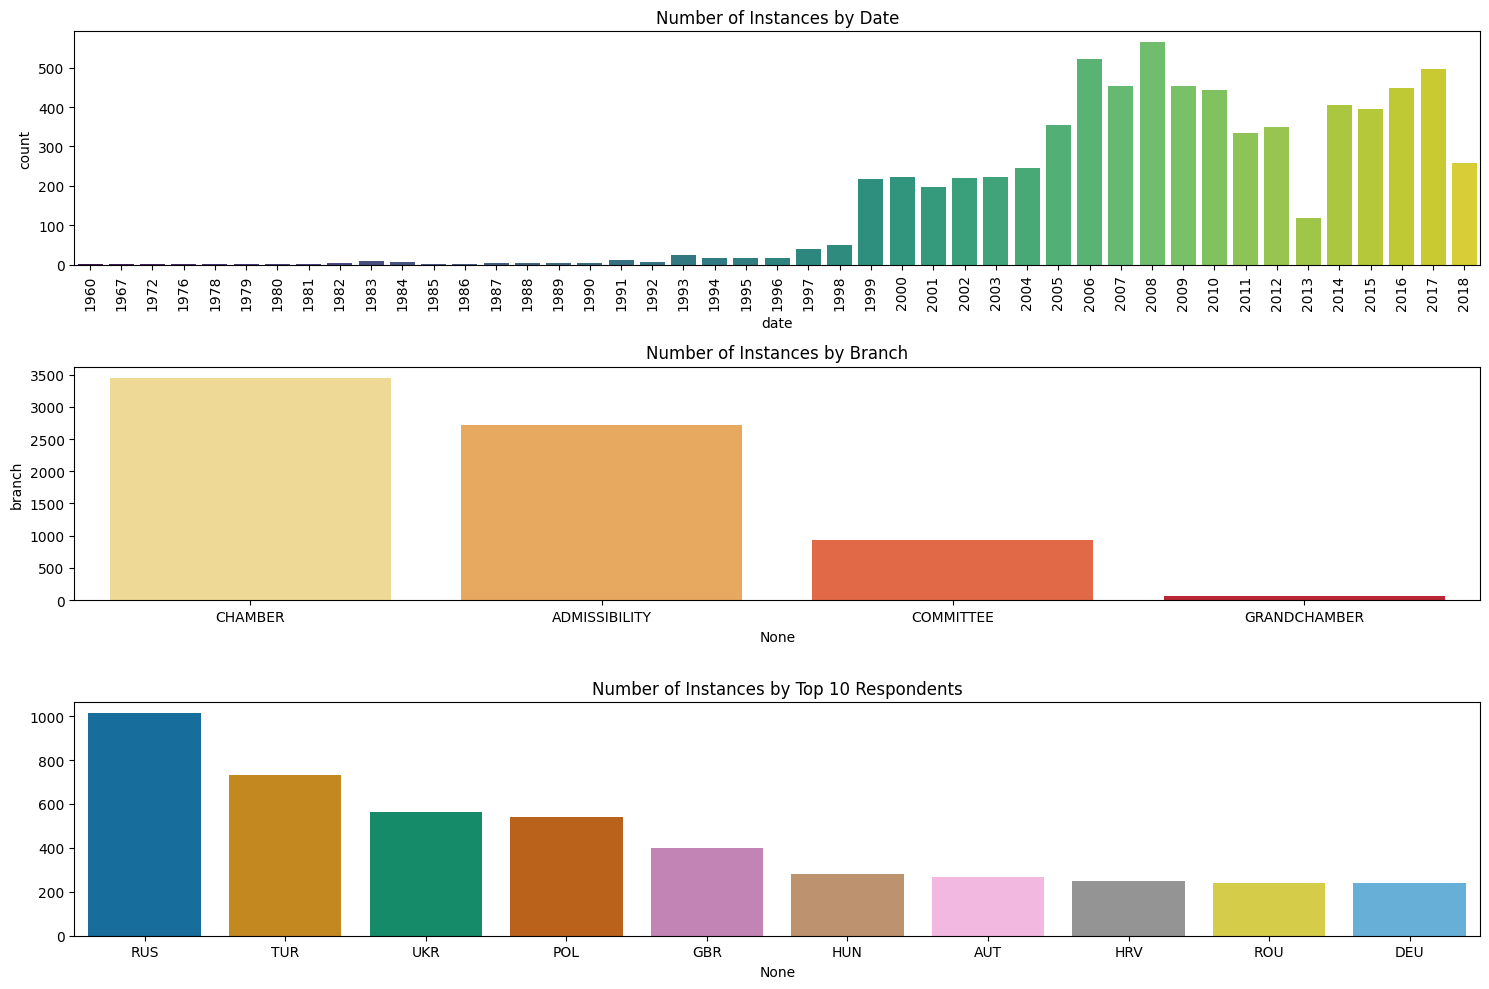

In [14]:
import seaborn as sns

plt.figure(figsize=(15, 10))

# Plot number of instances per date
plt.subplot(3, 1, 1)
sns.countplot(x='date', data=data, palette='viridis')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.title('Number of Instances by Date')

# Plot number of instances per branch
plt.subplot(3, 1, 2)
values = data['branch'].value_counts()
sns.barplot(x = values.index, y=values, palette='YlOrRd')
plt.title('Number of Instances by Branch')

# Plot number of instances per top 10 respondents
plt.subplot(3, 1, 3)
top_respondents = data['respondent'].value_counts().nlargest(10)
sns.barplot(x=top_respondents.index, y=top_respondents.values, palette='colorblind')
plt.title('Number of Instances by Top 10 Respondents')

plt.tight_layout()
plt.show()

Let's now look at how many cases in this dataset actually resulted in violations of human rights articles or protocols. This is typically called the *class label distribution*. It will give us an idea of the dataset *class balance* (or *class imbalance*), an important property to look out for when making modelling and evaluation decisions.

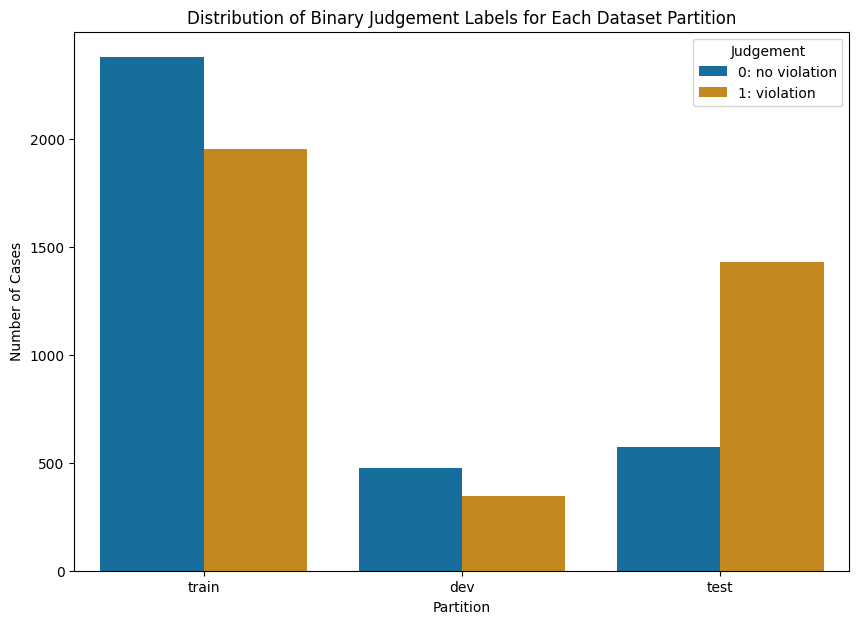

In [15]:
plt.figure(figsize=(10, 7))

# Plot binary class label distribution per partition
sns.countplot(
    x='partition',
    hue='binary_judgement',
    data=data,
    palette='colorblind',
    order=['train', 'dev', 'test']
)

# Annotate plot
plt.legend(title='Judgement', labels=['0: no violation', '1: violation'])
plt.title('Distribution of Binary Judgement Labels for Each Dataset Partition')
plt.xlabel('Partition')
plt.ylabel('Number of Cases')
plt.show()

Finally, let's look at the class distribution of importance scores. Remember: importance scores range from 1 (key case) to 4 (unimportant).

***Write code that plots the class distribution per data partition.***

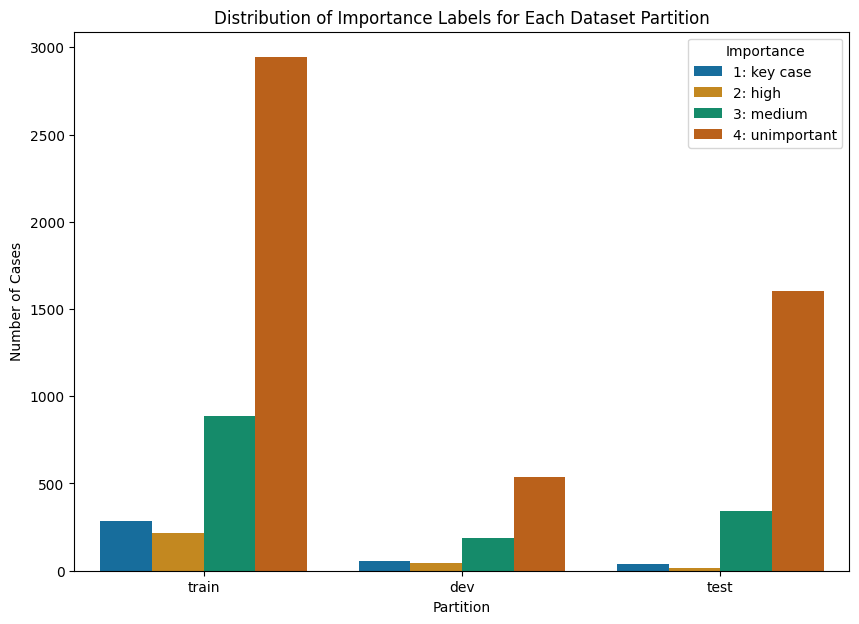

In [16]:
# Plot importance score distribution per partition

plt.figure(figsize=(10, 7))

# Plot importance label distribution per partition
sns.countplot(
    x='partition',
    hue='importance',
    data=data,
    palette='colorblind',
    order=['train', 'dev', 'test']
)

# Annotate plot
plt.legend(title='Importance', labels=['1: key case', '2: high', '3: medium', '4: unimportant'])
plt.title('Distribution of Importance Labels for Each Dataset Partition')
plt.xlabel('Partition')
plt.ylabel('Number of Cases')
plt.show()


## Binary Judgement Prediction with Bag of Words

Let's finally start with the task of predicting the outcome of a case given the text describing the main facts brought to the attention of the court. As we have just seen, each court case is annotated with a binary judgement label: whether the offendant has (label 1) or has not (label 0) violated any human rights article or protocol. This is a similar scenario to the sentiment classification task you have worked on previously in this course.

### Set-up
First, we load the necessary python libraries. Similarly to the sentiment classification example, we will use `keras` and `tensorflow`.

***Fix the random seed of `tensorflow` and `numpy` to ensure reproducibility.***

In [17]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant

# Initialize random number generators to ensure reproducibility
tf.random.set_seed(123)
np.random.seed(123)

In [18]:
# @title Convenience functions: prepare data splits in scikit-friendly format
# @markdown You don't need to read the code in this cell, but please make sure you execute it.

def load_input_from_ECHR_dataset(dataframe):
    # Input: text
    X_train = data[data.partition == 'train'].text.to_list()
    X_val = data[data.partition == 'dev'].text.to_list()
    X_test = data[data.partition == 'test'].text.to_list()
    return X_train, X_val, X_test

def load_binary_output_from_ECHR_dataset(dataframe):
    # Binary output: violation judgement
    y_train_binary = data[data.partition == 'train'].binary_judgement.to_numpy()
    y_val_binary = data[data.partition == 'dev'].binary_judgement.to_numpy()
    y_test_binary = data[data.partition == 'test'].binary_judgement.to_numpy()
    return y_train_binary, y_val_binary, y_test_binary

def load_regression_output_from_ECHR_dataset(dataframe):
    # Regression output: case importance score
    y_train_regression = data[data.partition == 'train'].importance.astype(float).to_numpy()
    y_val_regression = data[data.partition == 'dev'].importance.astype(float).to_numpy()
    y_test_regression = data[data.partition == 'test'].importance.astype(float).to_numpy()
    return y_train_regression, y_val_regression, y_test_regression

def load_multiclass_output_from_ECHR_dataset(dataframe):
    # Multiclass output: case importance label
    y_train_multiclass = data[data.partition == 'train'].importance.to_numpy()
    y_val_multiclass = data[data.partition == 'dev'].importance.to_numpy()
    y_test_multiclass = data[data.partition == 'test'].importance.to_numpy()
    return y_train_multiclass, y_val_multiclass, y_test_multiclass

def load_ECHR_dataset_for_binary_judgement_classification(dataframe, for_tensorflow=False):
    X_train, X_val, X_test = load_input_from_ECHR_dataset(dataframe)
    y_train, y_val, y_test = load_binary_output_from_ECHR_dataset(dataframe)
    if for_tensorflow:
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    else:
        train_ds = {"texts": X_train, "labels": y_train}
        val_ds = {"texts": X_val, "labels": y_val}
        test_ds = {"texts": X_test, "labels": y_test}
    return train_ds, val_ds, test_ds

def load_ECHR_dataset_for_case_importance_regression(dataframe, for_tensorflow=False):
    X_train, X_val, X_test = load_input_from_ECHR_dataset(dataframe)
    y_train, y_val, y_test = load_regression_output_from_ECHR_dataset(dataframe)
    if for_tensorflow:
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    else:
        train_ds = {"texts": X_train, "labels": y_train}
        val_ds = {"texts": X_val, "labels": y_val}
        test_ds = {"texts": X_test, "labels": y_test}
        return train_ds, val_ds, test_ds

def load_ECHR_dataset_for_case_importance_classification(dataframe, for_tensorflow=False):
    X_train, X_val, X_test = load_input_from_ECHR_dataset(dataframe)
    y_train, y_val, y_test = load_multiclass_output_from_ECHR_dataset(dataframe)
    if for_tensorflow:
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    else:
        train_ds = {"texts": X_train, "labels": y_train}
        val_ds = {"texts": X_val, "labels": y_val}
        test_ds = {"texts": X_test, "labels": y_test}
    return train_ds, val_ds, test_ds


### Loading the data

We now load the data in needed for the binary classification task in a model-friendly format, using some convenience functions defined in the cell above. As we have seen, the ECHR dataset comes with a predefined train-validation-test split.

In [19]:
train_ds, val_ds, test_ds = load_ECHR_dataset_for_binary_judgement_classification(data, for_tensorflow=True)

# Print 3 examples from the dataset
for example, label in train_ds.take(3):
  print("Input: ", example)
  print(10*".")
  print('Target labels: ', label)
  print(50*"-")


Input:  tf.Tensor(b'1. The applicants are seven Slovak nationals who live in Zemianske Kosto\xc4\xbeany. Their further particulars are set out in the appendix. They were represented by Mr J. Sedliak, a lawyer practising in Prievidza. The Government of the Slovak Republic (\xe2\x80\x9cthe Government\xe2\x80\x9d) were represented by their Agent, Mrs M. Piro\xc5\xa1\xc3\xadkov\xc3\xa1. 2. The facts of the case, as submitted by the parties, may be summarised as follows. 3. The applicants were elected as members of the Zemianske Kosto\xc4\xbeany Municipal Council for a four-year period from 1998 to 2002. The mayor prevented them from carrying out their functions and stopped paying remuneration to them for the period from 1 January 2001 to 16 December 2002. The applicants and another individual sued the municipality for unpaid remuneration totalling the equivalent of 3,591 euros (EUR). 4. As the municipality paid EUR 2,825 to them, the claimants decided to withdraw their claim in respect of 

### Fit and evaluate

The following piece of code defines a function that trains (fits) a model on the training data and evaluates it on the development set. It then returns the training and validation accuracy obtained by the model at training epoch.

Please take some time to read this code and to understand all of its components.

In [20]:
def fit_and_eval_binary_classifier(
    train_ds,
    val_ds,
    model,
    learning_rate,
    buffer_size,
    batch_size,
    n_epochs,
    patience_n_epochs=5
    ):

    # compile
    model.compile(
        loss='binary_crossentropy',
        metrics=['accuracy'],
        optimizer=Adam(learning_rate=learning_rate)
    )

    # preliminaries
    tf.random.set_seed(42)
    np.random.seed(42)
    tf.config.run_functions_eagerly(True)

    # train
    history = model.fit(
        train_ds.shuffle(buffer_size=buffer_size).batch(batch_size),
        validation_data=val_ds.batch(batch_size),
        epochs=n_epochs,
        verbose=1,
        callbacks=[EarlyStopping(
            monitor='val_accuracy', patience=patience_n_epochs, verbose=False, restore_best_weights=True
        )]
    )

    return history.history['accuracy'], history.history['val_accuracy']

Now that the data is loaded and the training and evaluation procedure is in place, we can move to modelling.

### Creating Bag-of-Words text representations

We will use [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) to obtain bag-of-words representations of texts.

These representations will depend on two main parameters:
* the vocabulary size `VOCAB_SIZE`, which limits the number of word considered to the `VOCAB_SIZE` most frequent ones
* the type of bag-of-words representation: based on raw word counts (`count`) or on word counts weighed by inverse document frequency (`tf-idf`)

***Write code to create count-based and tf-idf text representations.***

In [21]:
VOCAB_SIZE = 1000

# Create count-based features
# ----------------------------
encoder_bow_count = TextVectorization(max_tokens=VOCAB_SIZE, output_mode="count")
encoder_bow_count.adapt(train_ds.map(lambda text, label: text))

# Create tf-idf features
# ----------------------------
encoder_bow_tfidf = TextVectorization(max_tokens=VOCAB_SIZE, output_mode="tf_idf")
encoder_bow_tfidf.adapt(train_ds.map(lambda text, label: text))

In [22]:
# Let's take a peak at the vocabulary
vocab = np.array(encoder_bow_count.get_vocabulary())
vocab[:30]

array(['[UNK]', 'the', 'of', 'to', 'in', 'and', 'on', 'a', 'that',
       'court', 'applicant', 'was', 'had', 'for', 'by', 'as', 'be', 'not',
       'his', 'he', 'with', 'it', 'an', 'been', 'or', 'appeal', 'which',
       'is', 'proceedings', 'decision'], dtype='<U14')

### Binary classifier 1
As a first model, we will implement a logistic regression classifier with count-based BOW representations.

***Write code to define the model architecture, the training obectives, and the evaluation metric.***

In [23]:
# Define main hyperparameters
# --------------------------------------------------------------
LEARNING_RATE = 0.005
N_EPOCHS = 20
BUFFER_SIZE = 10000
BATCH_SIZE = 50


# Define model architecture
# --------------------------------------------------------------
binary_classifier_1 = Sequential(
    name = f'Logistic regression, count-based BOW, |V| = {VOCAB_SIZE}'
)
binary_classifier_1.add(Input(shape=(1,), dtype='string'))
binary_classifier_1.add(encoder_bow_count)
binary_classifier_1.add(Dense(1, activation="sigmoid"))


# Define training objective, evaluation metric, and optimizer
# --------------------------------------------------------------
binary_classifier_1.compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam(learning_rate=LEARNING_RATE)
)
print(binary_classifier_1.summary())


Model: "Logistic regression, count-based BOW, |V| = 1000"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 1000)              0         
 ctorization)                                                    
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 1001 (3.91 KB)
Trainable params: 1001 (3.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Let's fit and evaluate this first classifier.

In [24]:
# fit_and_eval_binary_classifier returns the training and validation accuracy scores over epochs
train_acc_model_1, val_acc_model_1, =  fit_and_eval_binary_classifier(
    train_ds=train_ds,
    val_ds=val_ds,
    model=binary_classifier_1,
    learning_rate=LEARNING_RATE,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    patience_n_epochs=N_EPOCHS
)

Epoch 1/20
87/87 [==============================] - 7s 49ms/step - loss: 1.5656 - accuracy: 0.6487 - val_loss: 0.5867 - val_accuracy: 0.7631
Epoch 2/20
87/87 [==============================] - 4s 43ms/step - loss: 0.4294 - accuracy: 0.8308 - val_loss: 0.5745 - val_accuracy: 0.8165
Epoch 3/20
87/87 [==============================] - 4s 42ms/step - loss: 0.3329 - accuracy: 0.8710 - val_loss: 0.4629 - val_accuracy: 0.8493
Epoch 4/20
87/87 [==============================] - 4s 43ms/step - loss: 0.2820 - accuracy: 0.8908 - val_loss: 0.5058 - val_accuracy: 0.8165
Epoch 5/20
87/87 [==============================] - 4s 44ms/step - loss: 0.2520 - accuracy: 0.9047 - val_loss: 0.5032 - val_accuracy: 0.8493
Epoch 6/20
87/87 [==============================] - 4s 44ms/step - loss: 0.2590 - accuracy: 0.8998 - val_loss: 0.4888 - val_accuracy: 0.8481
Epoch 7/20
87/87 [==============================] - 4s 41ms/step - loss: 0.2425 - accuracy: 0.9037 - val_loss: 0.5339 - val_accuracy: 0.8275
Epoch 8/20
87

These are its training and validation accuracy over epochs. (Note that the model stops training after `patience_n_epochs` where its loss doesn't improve. We set this value equal to the number of epochs, so the model completes them all. However, you can set this parameter to a lower value for more efficient training. This is what you'd likely do in practice.)

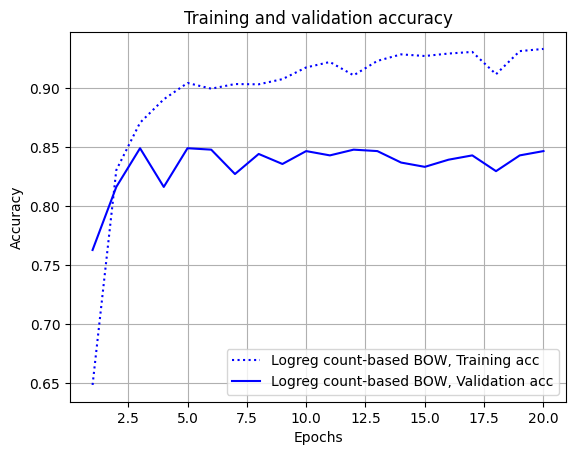

In [25]:
plt.plot(
    range(1, len(train_acc_model_1) + 1),  # the epochs for the x-axis
    train_acc_model_1,  # the training accuracy
    'b:',  # for dotted blue line
    label='Logreg count-based BOW, Training acc'
)
plt.plot(
    range(1, len(val_acc_model_1) + 1),  # the epochs for the x-axis
    val_acc_model_1,  # the validation accuracy
    'b',  # for dense blue line
    label='Logreg count-based BOW, Validation acc'
)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Binary classifier 2
Next is a logistic regression classifier with tfidf-based BOW representations.


***Write code to define the model architecture, the training obectives, and the evaluation metric.***

In [26]:
# Define main hyperparameters
# --------------------------------------------------------------
LEARNING_RATE = 0.005
N_EPOCHS = 20
BUFFER_SIZE = 10000
BATCH_SIZE = 50


# Define model architecture
# --------------------------------------------------------------
binary_classifier_2 = Sequential(
    name = f'Logistic regression, tfidf-based BOW, |V| = {VOCAB_SIZE}'
)
binary_classifier_2.add(Input(shape=(1,), dtype='string'))
binary_classifier_2.add(encoder_bow_tfidf)
binary_classifier_2.add(Dense(1, activation="sigmoid"))


# Define training objective, evaluation metric, and optimizer
# --------------------------------------------------------------
binary_classifier_2.compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam(lr=LEARNING_RATE)
)
print(binary_classifier_2.summary())


Model: "Logistic regression, tfidf-based BOW, |V| = 1000"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 1000)              1         
 Vectorization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 1002 (3.92 KB)
Trainable params: 1001 (3.91 KB)
Non-trainable params: 1 (8.00 Byte)
_________________________________________________________________
None


Fit and evaluate, then plot accuracy.

In [27]:
train_acc_model_2, val_acc_model_2, =  fit_and_eval_binary_classifier(
    train_ds=train_ds,
    val_ds=val_ds,
    model=binary_classifier_2,
    learning_rate=LEARNING_RATE,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    patience_n_epochs=N_EPOCHS
)

Epoch 1/20
87/87 [==============================] - 4s 43ms/step - loss: 1.1242 - accuracy: 0.7024 - val_loss: 0.6588 - val_accuracy: 0.7776
Epoch 2/20
87/87 [==============================] - 3s 40ms/step - loss: 0.4160 - accuracy: 0.8486 - val_loss: 0.6104 - val_accuracy: 0.8262
Epoch 3/20
87/87 [==============================] - 4s 40ms/step - loss: 0.3501 - accuracy: 0.8705 - val_loss: 0.5696 - val_accuracy: 0.8323
Epoch 4/20
87/87 [==============================] - 4s 45ms/step - loss: 0.3163 - accuracy: 0.8807 - val_loss: 0.5803 - val_accuracy: 0.8153
Epoch 5/20
87/87 [==============================] - 4s 44ms/step - loss: 0.2842 - accuracy: 0.8943 - val_loss: 0.6920 - val_accuracy: 0.8323
Epoch 6/20
87/87 [==============================] - 4s 41ms/step - loss: 0.2862 - accuracy: 0.8917 - val_loss: 0.7425 - val_accuracy: 0.7959
Epoch 7/20
87/87 [==============================] - 4s 43ms/step - loss: 0.2921 - accuracy: 0.8922 - val_loss: 0.8285 - val_accuracy: 0.7849
Epoch 8/20
87

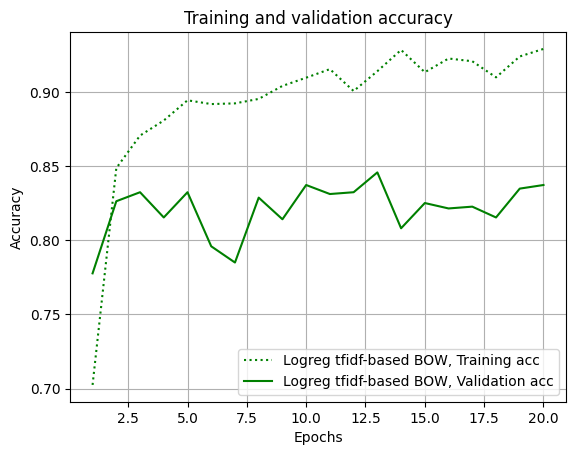

In [28]:
plt.plot(
    range(1, len(train_acc_model_2) + 1),
    train_acc_model_2,
    'g:',
    label='Logreg tfidf-based BOW, Training acc'
)
plt.plot(
    range(1, len(val_acc_model_2) + 1),
    val_acc_model_2,
    'g',
    label='Logreg tfidf-based BOW, Validation acc'
)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Model comparison

To compare the two models visually, ***plot the training and validation accuracy of the two bag-of-words models.***

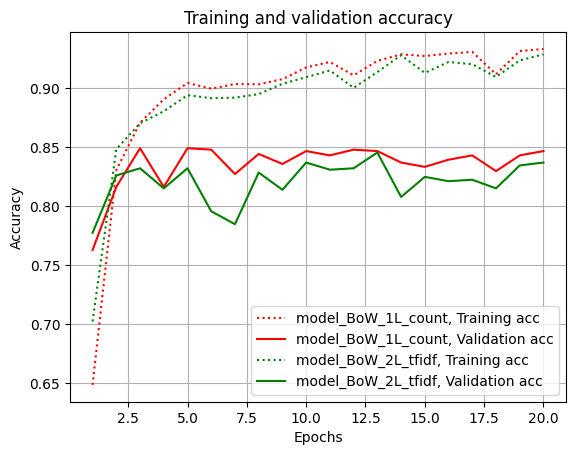

In [29]:
plt.plot(range(1, len(train_acc_model_1) + 1), train_acc_model_1, 'r:', label='model_BoW_1L_count, Training acc')
plt.plot(range(1, len(val_acc_model_1) + 1), val_acc_model_1,   'r',  label='model_BoW_1L_count, Validation acc')
plt.plot(range(1, len(train_acc_model_2) + 1), train_acc_model_2, 'g:', label='model_BoW_2L_tfidf, Training acc')
plt.plot(range(1, len(val_acc_model_2) + 1), val_acc_model_2,   'g',  label='model_BoW_2L_tfidf, Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

***Briefly describe the results.***

*Enter your response here (two or three sentences should suffice).*

### Analysis
To understand the models' performance beyond the evaluation scores, it is useful to carry out what could be called an *intepretability analysis*.

We interpret what the model has learned by analysing its weights.

***Write code to extract the weights from the two classifiers above and to obtain the vocabulary entries with the highest weights.***

In [30]:
vocab1 = np.array(encoder_bow_count.get_vocabulary())
vocab2 = np.array(encoder_bow_tfidf.get_vocabulary())

# Extract the classifier weights
classifier_1_vocab_weights = binary_classifier_1.layers[1].get_weights()[0]
classifier_2_vocab_weights = binary_classifier_2.layers[1].get_weights()[0]

# Sort the weights and get the correspondingly sorted vocabulary indices
classifier_1_vocab_weights_sorted = np.argsort(classifier_1_vocab_weights, axis=0)
classifier_2_vocab_weights_sorted = np.argsort(classifier_2_vocab_weights, axis=0)

# The indices with the largest values indicate which words are most indicative of violations
print("Words predictive of violations")
print("Model 1:\n", vocab1[classifier_1_vocab_weights_sorted[-10:]])
print()
print("Model 2:\n", vocab2[classifier_2_vocab_weights_sorted[-10:]])

# ... and vice versa
print("\n\nWords predictive of absolution")
print("Model 1:\n", vocab1[classifier_1_vocab_weights_sorted[:10]])
print("Model 2:\n", vocab2[classifier_2_vocab_weights_sorted[:10]])

Words predictive of violations
Model 1:
 [['events']
 ['professional']
 ['very']
 ['6']
 ['initiated']
 ['competent']
 ['requests']
 ['11']
 ['institution']
 ['illtreatment']]

Model 2:
 [['competent']
 ['16']
 ['13']
 ['22']
 ['10']
 ['19']
 ['17']
 ['7']
 ['6']
 ['11']]


Words predictive of absolution
Model 1:
 [['government”']
 ['represented']
 ['practising']
 ['summarised']
 ['nationals']
 ['agent']
 ['polish']
 ['facts']
 ['subsection']
 ['national']]
Model 2:
 [['government”']
 ['summarised']
 ['practising']
 ['represented']
 ['agent']
 ['nationals']
 ['facts']
 ['national']
 ['currently']
 ['polish']]


Do the words with the highest weights correspond to sensible violation or absolution cues?

## Binary Judgement Prediction with LSTMs

As a next model class, we will consider recurrent neural models — in particular, LSTMs. As you have learned, these models are able to take into account the order of words in sentences, which is in principle a big advantage over bag-of-words models. "The woman sued Switzerland" is not the same as "Switzerland sued the woman"!

### BiLSTM with embeddings trained from scratch

First, we'll design a simple one-layer bidirectional LSTM with word embeddings learned from scratch.

***Write code to create word embeddings for the vocabulary of this dataset.***

First, define the right encoder.

In [31]:
EMBEDDING_DIM = 50
VOCAB_SIZE = 1000

encoder_embed = TextVectorization(max_tokens=VOCAB_SIZE)
encoder_embed.adapt(train_ds.map(lambda text, label: text))

# print the vocabulary id of the word "human"
encoder_embed("human").numpy()

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([491])

Then, create the embedding matrix.

In [32]:
embedding_layer = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    embeddings_initializer="uniform",
    trainable=True,
)

***Write code to define the model architecture***. Remember, this should include an input layer, encoder and embedding layers, a bidirectional LSTM layer and an output layer. Keep the dimensionality of the LSTM layer low (for example, 16).

In [33]:
binary_classifier_3 = Sequential(
    name=f"1-layer BiLSTM classifier, embeddings from scratch)"
)
binary_classifier_3.add(Input(shape=(1,), dtype='string'))
binary_classifier_3.add(encoder_embed)
binary_classifier_3.add(embedding_layer)
binary_classifier_3.add(Bidirectional(LSTM(64)))
binary_classifier_3.add(Dense(1, activation="sigmoid"))

binary_classifier_3.summary()

Model: "1-layer BiLSTM classifier, embeddings from scratch)"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, None, 50)          50000     
                                                                 
 bidirectional (Bidirection  (None, 128)               58880     
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 109009 (425.82 KB)
Trainable params: 109009 (425.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________

Fit and evaluate. Note: the LSTM takes longer to train than the logistic regression. We set the patience parameter to 5 to avoid redundant epochs.

In [34]:
LEARNING_RATE = 0.005
BATCH_SIZE = 50
BUFFER_SIZE = 10000
N_EPOCHS = 20

train_acc_model_3, val_acc_model_3, =  fit_and_eval_binary_classifier(
    train_ds=train_ds,
    val_ds=val_ds,
    model=binary_classifier_3,
    learning_rate=LEARNING_RATE,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    patience_n_epochs=5
)

Epoch 1/20
87/87 [==============================] - 16s 182ms/step - loss: 0.3623 - accuracy: 0.8479 - val_loss: 0.2414 - val_accuracy: 0.9089
Epoch 2/20
87/87 [==============================] - 16s 181ms/step - loss: 0.2406 - accuracy: 0.9056 - val_loss: 0.2429 - val_accuracy: 0.9077
Epoch 3/20
87/87 [==============================] - 16s 181ms/step - loss: 0.2321 - accuracy: 0.9070 - val_loss: 0.2386 - val_accuracy: 0.9040
Epoch 4/20
87/87 [==============================] - 16s 189ms/step - loss: 0.2209 - accuracy: 0.9081 - val_loss: 0.2408 - val_accuracy: 0.9089
Epoch 5/20
87/87 [==============================] - 16s 179ms/step - loss: 0.2010 - accuracy: 0.9201 - val_loss: 0.2486 - val_accuracy: 0.8991
Epoch 6/20
87/87 [==============================] - 16s 181ms/step - loss: 0.1982 - accuracy: 0.9227 - val_loss: 0.2403 - val_accuracy: 0.9089


### Deeper network
Next, let's try with a deeper two-layer LSTM network. Word embeddings will be still learned from scratch.


***Define the full two-layer Bidirectional LSTM in the cell below.***  This is identical to the one-layer model, but with an extra Bidirectional LSTM layer. Again, keep the dimensionality of the LSTM layers low.

In [35]:
encoder_embed = TextVectorization(max_tokens=VOCAB_SIZE)
encoder_embed.adapt(train_ds.map(lambda text, label: text))

embedding_layer = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    embeddings_initializer="uniform",
    trainable=True,
)

binary_classifier_4 = Sequential(
    name=f"2-layer BiLSTM classifier (embeddings from scratch)"
)
binary_classifier_4.add(Input(shape=(1,), dtype='string'))
binary_classifier_4.add(encoder_embed)
binary_classifier_4.add(embedding_layer)
binary_classifier_4.add(Bidirectional(LSTM(32, return_sequences=True)))
binary_classifier_4.add(Bidirectional(LSTM(16)))
binary_classifier_4.add(Dense(1, activation="sigmoid"))

binary_classifier_4.summary()

Model: "2-layer BiLSTM classifier (embeddings from scratch)"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          50000     
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 64)          21248     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
               

Fit and evaluate.

In [36]:
LEARNING_RATE = 0.005
BATCH_SIZE = 50
BUFFER_SIZE = 10000
N_EPOCHS = 20

train_acc_model_4, val_acc_model_4, =  fit_and_eval_binary_classifier(
    train_ds=train_ds,
    val_ds=val_ds,
    model=binary_classifier_4,
    learning_rate=LEARNING_RATE,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    patience_n_epochs=5
)


Epoch 1/20
87/87 [==============================] - 27s 305ms/step - loss: 0.3264 - accuracy: 0.8684 - val_loss: 0.2531 - val_accuracy: 0.9064
Epoch 2/20
87/87 [==============================] - 26s 304ms/step - loss: 0.2445 - accuracy: 0.9070 - val_loss: 0.2863 - val_accuracy: 0.9028
Epoch 3/20
87/87 [==============================] - 27s 311ms/step - loss: 0.2393 - accuracy: 0.9065 - val_loss: 0.2485 - val_accuracy: 0.9077
Epoch 4/20
87/87 [==============================] - 27s 306ms/step - loss: 0.2198 - accuracy: 0.9074 - val_loss: 0.2519 - val_accuracy: 0.9077
Epoch 5/20
87/87 [==============================] - 26s 299ms/step - loss: 0.2178 - accuracy: 0.9056 - val_loss: 0.2650 - val_accuracy: 0.9077
Epoch 6/20
87/87 [==============================] - 26s 300ms/step - loss: 0.2039 - accuracy: 0.9151 - val_loss: 0.2680 - val_accuracy: 0.9016
Epoch 7/20
87/87 [==============================] - 27s 306ms/step - loss: 0.1906 - accuracy: 0.9234 - val_loss: 0.2786 - val_accuracy: 0.8882

To compare the two bidirectional LSTMs, ***plot the training and validation accuracy of the two models.***

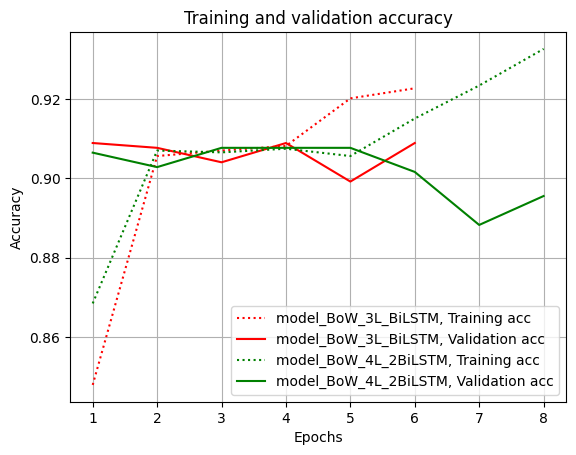

In [37]:
plt.plot(range(1, len(train_acc_model_3) + 1), train_acc_model_3, 'r:', label='model_BoW_3L_BiLSTM, Training acc')
plt.plot(range(1, len(val_acc_model_3) + 1), val_acc_model_3,   'r',  label='model_BoW_3L_BiLSTM, Validation acc')
plt.plot(range(1, len(train_acc_model_4) + 1), train_acc_model_4, 'g:', label='model_BoW_4L_2BiLSTM, Training acc')
plt.plot(range(1, len(val_acc_model_4) + 1), val_acc_model_4,   'g',  label='model_BoW_4L_2BiLSTM, Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Pre-trained word embeddings

The dataset at hand is very domain-specific and not particularly large so it is unlikely that the model will be able learn the general meaning of words. Luckily the network can be initialised with pre-trained word embeddings, which were trained on generalist corpora to capture the meaning of all words in the vocabulary. We will download pre-trained GloVe embeddings of dimensionality 50, trained on a corpus of 6 billion tokens.

In [38]:
 !wget http://nlp.stanford.edu/data/glove.6B.zip
 !unzip -q glove.6B.zip

--2024-04-01 06:43:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-01 06:43:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-01 06:43:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [39]:
# Load pre-trained GloVe embeddings
# ----------------------------------
glove_file_path = 'glove.6B.50d.txt'
EMBEDDING_DIM = 50

embeddings_index = {}
with open(glove_file_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for i, word in enumerate(encoder_embed.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        print(word)

print("Converted %d words (%d misses)" % (hits, misses))


Found 400000 word vectors.

[UNK]
applicant’s
“the
§
court’s
firstinstance
§§
prosecutor’s
timelimit
applicants’
“1
nonpecuniary
years’
government”
sąd
act”
caselaw
court”
illtreatment
Converted 980 words (20 misses)


#### Frozen embeddings

Here, we are going to leave the word embeddings "frozen". That is, they will not be updated throughout the training of the LSTM. In this way, the embeddings will remain general representations of word meaning while the rest of the network will specialise for the legal judgement prediction task.

***Define a Bidirectional LSTM with frozen, pre-trained word embeddings.*** You can make the LSTM one-layer for faster training.

In [40]:
pretrained_embedding_layer_frozen = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False
)

binary_classifier_5 = Sequential(
    name=f"1-layer BiLSTM classifier (frozen pre-trained embeddings)"
)
# Fill in the following lines to build the LSTM
binary_classifier_5.add(Input(shape=(1,), dtype='string'))
binary_classifier_5.add(encoder_embed)
binary_classifier_5.add(pretrained_embedding_layer_frozen)
binary_classifier_5.add(Bidirectional(LSTM(64)))
binary_classifier_5.add(Dense(1, activation="sigmoid"))

binary_classifier_5.summary()

Model: "1-layer BiLSTM classifier (frozen pre-trained embeddings)"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, None, 50)          50000     
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               58880     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 109009 (425.82 KB)
Trainable params: 59009 (230.50 KB)
Non-trainable params: 50000 (195.31 KB)
________________________________

Fit and evaluate.

In [41]:
LEARNING_RATE = 0.005
BATCH_SIZE = 50
BUFFER_SIZE = 10000
N_EPOCHS = 20

train_acc_model_5, val_acc_model_5, =  fit_and_eval_binary_classifier(
    train_ds=train_ds,
    val_ds=val_ds,
    model=binary_classifier_5,
    learning_rate=LEARNING_RATE,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    patience_n_epochs=5
)


Epoch 1/20
87/87 [==============================] - 19s 213ms/step - loss: 0.3020 - accuracy: 0.8848 - val_loss: 0.2651 - val_accuracy: 0.9028
Epoch 2/20
87/87 [==============================] - 19s 217ms/step - loss: 0.2530 - accuracy: 0.9047 - val_loss: 0.2480 - val_accuracy: 0.9077
Epoch 3/20
87/87 [==============================] - 19s 215ms/step - loss: 0.2513 - accuracy: 0.9051 - val_loss: 0.2509 - val_accuracy: 0.9077
Epoch 4/20
87/87 [==============================] - 21s 240ms/step - loss: 0.2450 - accuracy: 0.9056 - val_loss: 0.2461 - val_accuracy: 0.9064
Epoch 5/20
87/87 [==============================] - 21s 245ms/step - loss: 0.2441 - accuracy: 0.9065 - val_loss: 0.2448 - val_accuracy: 0.9064
Epoch 6/20
87/87 [==============================] - 19s 215ms/step - loss: 0.2415 - accuracy: 0.9074 - val_loss: 0.2458 - val_accuracy: 0.9077
Epoch 7/20
87/87 [==============================] - 20s 228ms/step - loss: 0.2322 - accuracy: 0.9107 - val_loss: 0.2416 - val_accuracy: 0.9064

#### Adaptive embeddings

Now let's unfreeze the embeddings and allow them to be updated throughout training.

***Define a Bidirectional LSTM with adaptive embeddings.***

In [42]:
pretrained_embedding_layer_adaptive = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=True
)

binary_classifier_6 = Sequential(
    name=f"1-layer BiLSTM classifier (frozen pre-trained embeddings)"
)
# Fill in the following lines to build the LSTM
binary_classifier_6.add(Input(shape=(1,), dtype='string'))
binary_classifier_6.add(encoder_embed)
binary_classifier_6.add(pretrained_embedding_layer_frozen)
binary_classifier_6.add(Bidirectional(LSTM(64)))
binary_classifier_6.add(Dense(1, activation="sigmoid"))

binary_classifier_6.summary()

Model: "1-layer BiLSTM classifier (frozen pre-trained embeddings)"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, None, 50)          50000     
                                                                 
 bidirectional_4 (Bidirecti  (None, 128)               58880     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 109009 (425.82 KB)
Trainable params: 59009 (230.50 KB)
Non-trainable params: 50000 (195.31 KB)
________________________________

In [43]:
LEARNING_RATE = 0.005
BATCH_SIZE = 50
BUFFER_SIZE = 10000
N_EPOCHS = 20

train_acc_model_6, val_acc_model_6, =  fit_and_eval_binary_classifier(
    train_ds=train_ds,
    val_ds=val_ds,
    model=binary_classifier_6,
    learning_rate=LEARNING_RATE,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS
)


Epoch 1/20
87/87 [==============================] - 20s 225ms/step - loss: 0.3072 - accuracy: 0.8758 - val_loss: 0.2615 - val_accuracy: 0.8955
Epoch 2/20
87/87 [==============================] - 21s 239ms/step - loss: 0.2547 - accuracy: 0.9054 - val_loss: 0.2490 - val_accuracy: 0.9077
Epoch 3/20
87/87 [==============================] - 21s 240ms/step - loss: 0.2523 - accuracy: 0.9051 - val_loss: 0.2552 - val_accuracy: 0.9052
Epoch 4/20
87/87 [==============================] - 20s 224ms/step - loss: 0.2453 - accuracy: 0.9060 - val_loss: 0.2484 - val_accuracy: 0.9077
Epoch 5/20
87/87 [==============================] - 19s 215ms/step - loss: 0.2431 - accuracy: 0.9051 - val_loss: 0.2435 - val_accuracy: 0.9077
Epoch 6/20
87/87 [==============================] - 21s 239ms/step - loss: 0.2414 - accuracy: 0.9058 - val_loss: 0.2436 - val_accuracy: 0.9077
Epoch 7/20
87/87 [==============================] - 22s 247ms/step - loss: 0.2318 - accuracy: 0.9086 - val_loss: 0.2516 - val_accuracy: 0.9064

***Plot the training and validation accuracy of the four LSTM models.***

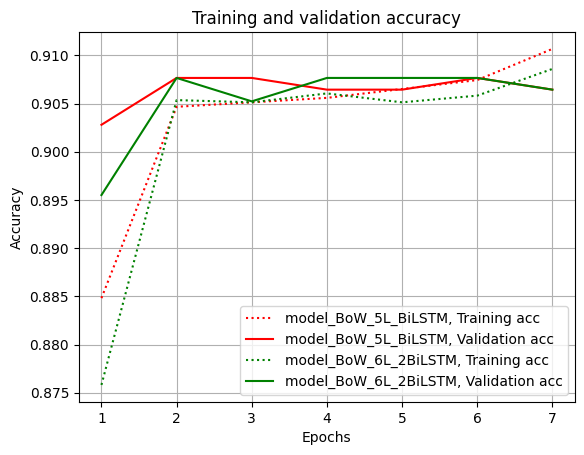

In [44]:
plt.plot(range(1, len(train_acc_model_5) + 1), train_acc_model_5, 'r:', label='model_BoW_5L_BiLSTM, Training acc')
plt.plot(range(1, len(val_acc_model_5) + 1), val_acc_model_5,   'r',  label='model_BoW_5L_BiLSTM, Validation acc')
plt.plot(range(1, len(train_acc_model_6) + 1), train_acc_model_6, 'g:', label='model_BoW_6L_2BiLSTM, Training acc')
plt.plot(range(1, len(val_acc_model_6) + 1), val_acc_model_6,   'g',  label='model_BoW_6L_2BiLSTM, Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## [OPTIONAL] Binary Judgement Prediction with Transformer language models

The last model class we'll experiment with are Transformer language models. We will *not* train a model from scratch on this dataset because Transformer language models are typically very large networks, with million of parameters, which would likely overfit to the dataset at hand. Instead, we will use a pre-trained language model, an autoregressive Transformer optimised to predict the next word in texts of many different domains.

We suggest you use [GPT-neo-125m](https://huggingface.co/EleutherAI/gpt-neo-125m), a model designed to replicate the architecture of OpenAI's GPT-3 in its smallest version (125 million parameters). Feel free to substitute this with another pretrained autoregressive language model from the Hugging Face [model hub](https://huggingface.co/models?sort=trending) but beware of model size.

If you are running this notebook on Google colab, *change the runtime type to `T4-GPU` using the dropdown menu on the top right.* After that, you might need to reload the data and the convenience functions defined above.


First, let's install and load the necessary python libraries. If you run this notebook in the ETH Jupyter hub, you can directly load the libraries. If not, please install using the cell below and restart the Runtime session.

In [45]:
!pip install transformers sacremoses accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [46]:
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
from torch.utils.data import Dataset, DataLoader
import torch


In [47]:
# @title Convenience functions for Huggingface transformers
# @markdown You don't need to read the code in this cell, but please make sure you execute it.

def load_classification_model_and_tokenizer(model_name_or_path):
    lm = AutoModelForSequenceClassification.from_pretrained(model_name_or_path)

    # Load the tokenizer suitable for this model
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

    if not lm.config.pad_token_id:
        lm.config.pad_token_id = lm.config.eos_token_id
        tokenizer.pad_token = tokenizer.eos_token

    return lm, tokenizer

class EHRCDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx],
                                  truncation=True,
                                  padding='max_length',
                                  max_length=self.max_length,
                                  return_attention_mask=True,
                                  return_tensors='pt')

        item = {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

        return item


def finetune_lm(model, train_dataset, val_dataset, n_epochs, batch_size, learning_rate, output_dir):
    # Training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=n_epochs,
        logging_dir="./logs",
        load_best_model_at_end=True,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        save_total_limit=1,
        learning_rate=learning_rate
    )

    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=lambda p: {"accuracy": accuracy_score(p.predictions.argmax(-1), p.label_ids)},
    )

    # Train the model
    trainer.train()

    return model, trainer


Load the data in model-friendly format using the convenience functions above.

In [48]:
# Load the data using our convenience functions
train_ds, val_ds, test_ds = load_ECHR_dataset_for_binary_judgement_classification(data)

# Load the tokenizer suitable for the model model
MODEL_NAME = "EleutherAI/gpt-neo-125m"
lm, tokenizer = load_classification_model_and_tokenizer(MODEL_NAME)

# Create dataset and data loaders for training and validation
train_dataset = EHRCDataset(train_ds['texts'], train_ds['labels'], tokenizer, max_length=2048)
val_dataset = EHRCDataset(val_ds['texts'], val_ds['labels'], tokenizer, max_length=2048)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

### Zero-shot classification and prompting

Note that this model is pre-trained on the general language modelling task (predicting the next word in a text) and not on the legal judgement prediction task. This is different from the setup you have seen in the tutorial on pre-trained Transformers. The type of classification we will perform with this model is typically referred to as *zero-shot classification*, meaning that the model is asked to classify by seeing *no* examples from the dataset.

In [50]:
zero_shot_classifier = pipeline(
    "zero-shot-classification",
    model=MODEL_NAME,
    device="cuda:0"
)

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


Instead of using a `text-classification` pipeline, we are using a `zero-shot-classification` pipeline. These two are almost equivalent except that `zero-shot-classification` doesn't require a hardcoded number of potential classes. They can be chosen at runtime:

In [51]:
candidate_labels = ["innocent", "guilty"]
label2id = {label: i for i, label in enumerate(candidate_labels)}


Why should this work? The language model is essentially asked if "innocent" is more or less likely to follow the court case text then "guilty".

But does it work in practice?

In [52]:
predictions_binary_classifier_7 = []

for text in tqdm(val_ds["texts"]):

    # Forward pass of zero-shot classification
    result = zero_shot_classifier(
        text,
        candidate_labels
    )

    # Get the model prediction (labels ordered according to their probability)
    prediction = label2id[result["labels"][0]]
    predictions_binary_classifier_7.append(prediction)

# Calculate the accuracy
acc_classifier7 = accuracy_score(val_ds["labels"], predictions_binary_classifier_7)
print("\nAccuracy:", acc_classifier7)

  0%|          | 0/823 [00:00<?, ?it/s]

Tokenizer was not supporting padding necessary for zero-shot, attempting to use  `pad_token=eos_token`
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/usr/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/usr/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/


Accuracy: 0.5735115431348724


To further steer the model towards giving sensible answers, it is good practice to prepend or append a templated string to the input example. In this case, we could for instance use the template "The party being sued in this court case is", which makes the model much less surprised to see "innocent" or "guilty" as continuations and gives the model a context to interpret those continuations as we would like it to. This technique is referred to as *prompting*.


In [53]:
prompt = "The party being sued in this court case is {}"
candidate_labels = ["innocent", "guilty"]
label2id = {label: i for i, label in enumerate(candidate_labels)}

Does this work better?

In [54]:
predictions_binary_classifier_8 = []

for text in tqdm(val_ds["texts"]):

    # Forward pass of zero-shot classification
    result = zero_shot_classifier(
        text,
        candidate_labels,
        hypothesis_template=prompt  # here we prompt the model with our template
    )

    # Get the model prediction (labels ordered according to their probability)
    prediction = label2id[result["labels"][0]]
    predictions_binary_classifier_8.append(prediction)

# Calculate the accuracy
acc_classifier8 = accuracy_score(val_ds["labels"], predictions_binary_classifier_8)
print("\nAccuracy:", acc_classifier8)


  0%|          | 0/823 [00:00<?, ?it/s]


Accuracy: 0.43377885783718106


***Try at least one more combination of prompt and labels and test the corresponding zero-shot classifier.***

In [55]:
# prompt = "..."  # fill in a prompt
# candidate_labels = ["...", "..."]  # fill in potential labels
prompt = "Is this a case of 'violation' of human rights or a case of 'absolution'? It is a case of {}"
candidate_labels = ["violation", "absolution"]  # fill in potential labels
label2id = {label: i for i, label in enumerate(candidate_labels)}

predictions_binary_classifier_9 = []

for text in tqdm(val_ds["texts"]):
  result = zero_shot_classifier(
        text,
        candidate_labels,
        hypothesis_template=prompt
    )

  prediction = label2id[result["labels"][0]]
  predictions_binary_classifier_9.append(prediction)


acc_classifier9 = accuracy_score(val_ds["labels"], predictions_binary_classifier_9)
print("\nAccuracy:", acc_classifier9)

  0%|          | 0/823 [00:00<?, ?it/s]


Accuracy: 0.543134872417983


### Fine-tuning

Finally, we fine-tune the pre-trained language model on the binary prediction task. By showing it examples of court cases and supervised labels, we obtain a Transformer model specialized for the judgement prediction task. Note that this might result in the model forgetting previous knowledge and becoming less performant in other tasks, including next-word prediction.

Let's launch the fine-tuning and save the fine-tuned model checkpoint.

In [1]:
N_EPOCHS = 5
BATCH_SIZE = 3
LEARNING_RATE = 1e-5
OUTPUT_DIR = "lm_for_classification_5ep"

lm_finetuned, lm_trainer = finetune_lm(lm, train_dataset, val_dataset, N_EPOCHS, BATCH_SIZE, LEARNING_RATE, OUTPUT_DIR)

# Save or use the trained model as needed
lm.save_pretrained(OUTPUT_DIR)

NameError: name 'finetune_lm' is not defined

Now we obtain predictions from the model and evaluate its accuracy.

In [ ]:
# List to store predicted labels
predictions_binary_classifier_10 = []

# Tokenize and predict labels for each example in the dataset
for text in val_ds['texts']:

    # Tokenize input text
    tokenized_input = tokenizer(text, return_tensors='pt')

    # Forward pass
    output = lm_finetuned(**tokenized_input)

    # Get predicted label
    predicted_label = torch.argmax(output.logits, dim=1).item()

    # Store predicted label in the list
    predictions_binary_classifier_10.append(predicted_label)

# Calculate the accuracy
acc_classifier10 = accuracy_score(val_ds["labels"], predictions_binary_classifier_10)
print(acc_classifier10)

In [ ]:
accuracy_score(val_ds["labels"], predictions_binary_classifier_10)

## Evaluate on the test set

You have compared at least 10 different classifiers so far. ***Now evaluate the best 3 on the test set and report their accuracy.***

In [ ]:
# Load test set

_, _, test_set = load_ECHR_dataset_for_binary_judgement_classification(data)

test_documents = test_set['texts']
test_labels = test_set['labels']


Example evaluation with logistic regression classifiers and LSTMs.

In [ ]:
from sklearn.metrics import classification_report

# Make prediction for the test set sentences
predictions = binary_classifier_1.predict(
    test_documents
)

# Turn predicted probabilities into binary classification scores
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Evaluate model by comparing its prediction to the gold labels
report = classification_report(
    y_true=test_labels,
    y_pred=binary_predictions
)

print(report)

Example evaluation with Transformers.

In [ ]:
prompt = "Is this a case of 'violation' of human rights or a case of 'absolution'? It is a case of {}"
candidate_labels = ["violation", "absolution"]  # fill in potential labels
label2id = {label: i for i, label in enumerate(candidate_labels)}

zero_shot_classifier = pipeline(
    "zero-shot-classification",
    model="EleutherAI/gpt-neo-125m",
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# Make predictions with Transformers
binary_predictions = []

for text in test_documents:
    # Forward pass of zero-shot classification
    result = zero_shot_classifier(
        text,
        candidate_labels,
        hypothesis_template=prompt
    )

    # Get the model prediction (labels ordered according to their probability)
    prediction = label2id[result["labels"][0]]
    binary_predictions.append(prediction)

# Evaluation report
report = classification_report(
    y_true=test_labels,
    y_pred=binary_predictions
)

print(report)


## [Optional] Case importance prediction

The main task of this project was binary legal judgement classification but each court case in the ECHR dataset is also annotated with importance scores, a value from 1 to 4 that allows legal practitioners to identify pivotal cases.

> Note: Importance scores can be thought of as values on a continuous scale from 1 to 4, or they can be considered as four separate classes, each with its specific meaning. Depending on which interpretation we decide to go with, predicting importance scores can be cast as a:
*   *regression task*: predicting a continous score from 1 to 4
*   *multi-class classification*: predicting a categorical label out ot 4 options

**Your (optional and open-ended) task is now to train and compare multi-class classifiers that predict the importance score of a court case.**




In [ ]:
# ...